# **Hyperparameters**

In [ ]:
RANDOM_SEED = 42
TAREGT_SIZE_TUPLE = (512, 512)
DATASET_FRAC_TO_USE = 1 #(1 = 100% of the dataset)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1
CLUSTEING_CENTROIDS_DIFFERENCE_TOLERANCE = 1e-4
DENSE_LAYER_UNITS = 128
LEARNING_RATE = 0.001
IMAGE_DATA_GENERATOR_RORATION_ANGLE = 20
BATCH_SIZE = 16
EPOCHS = 10

# **Functions used**


In [2]:
# os.walk
# os.listdir
# random.sample
# Image.open
# img.convert
# img.resize
# np.array
# np.stack
# np.random.normal
# np.max
# np.mean
# np.maximum
# np.linalg.norm
# np.argmin
# np.all
# np.argmax
# np.random.choice
# imagehash.phash
# pd.DataFrame
# plt (from matplotlib)
# train_test_split
# series.value_counts
# PCA()
# pca.fit_transform
# series.unique
# pd.Series()
# series.mode

# models.Sequential()
# layers.Conv2D()
# layers.MaxPooling2D()
# layers.Flatten()
# layers.Dense()
# model.compile
# tf.keras.optimizers.Adam()
# ReduceLROnPlateau()
# EarlyStopping()
# ImageDataGenerator()
# datagen.flow_from_dataframe

# **Milestone 2**

### Packages installation

In [3]:
!pip install kagglehub
!pip install imagehash
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
print("done installing packages")


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
done installing packages


### imports

In [4]:
import os
import kagglehub
import random
from PIL import Image
import imagehash
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.decomposition import PCA
from time import time

print("done importing packages")


/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-28 10:01:50.243891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 10:01:50.451480: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 10:01:50.672169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745823710.829484   19215 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745823710.873824   19215 cuda_blas

done importing packages


## **Data preparaion**

### Dataset path

In [5]:
if 'COLAB_GPU' in os.environ:
    dataset_folder = kagglehub.dataset_download('hussainghoraba/emotions-dataset')
    DATASET_PATH = os.path.join(dataset_folder, 'Dataset')
elif 'KAGGLE_URL_BASE' in os.environ:
    DATASET_PATH = '/kaggle/input/emotions-dataset/Dataset'
elif 'VSCODE_PID' in os.environ:
    DATASET_PATH = './Dataset'
else:
    raise Exception('Unknown environment')

print("done setting up dataset path")

done setting up dataset path


### Set random seed for consistent outputs through multiple runs

In [6]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
print("done setting up random seed")

done setting up random seed


### Helper functions

In [7]:
def calculate_and_print_time(start_time, section_name):
    end_time = time()
    time_taken = end_time - start_time
    hours = int(time_taken // 3600)
    minutes = int((time_taken % 3600) // 60)
    seconds = int((time_taken % 3600) % 60)
    print(f'\n{section_name} Done in : {hours} h, {minutes} m, {seconds} s')
    
def extend_depth(filters, depth):
    return np.stack([filters] * depth, axis=-1)

def get_image_flattened_windows(input_data, filter_size):
    input_h, input_w, input_c = input_data.shape
    output_h = input_h - filter_size + 1
    output_w = input_w - filter_size + 1

    col = np.zeros((output_h * output_w, filter_size * filter_size * input_c))
    i = 0
    for h in range(output_h):
        for w in range(output_w):
            cube = input_data[h:h+filter_size, w:w+filter_size, :]
            # flatten the window, for fast matrix multiplication in conv layer
            col[i, :] = cube.flatten()
            i += 1
    return col

def downsample_features(features_arrays):
    # downsample the features arrays to only 128 dimensions
    # use PCA only if we have more than 128 feature arrays ,
    # this is because in PCA, the number of components (which is 128 in our case) 
    # must be less than the number of samples.
    # if we have less than 128 feature arrays, we will just select random 128 features
    if features_arrays.shape[0] >= 128:
        print(f"appling PCA for features downsampling...")
        features_arrays = PCA(n_components=128).fit_transform(features_arrays)
    else:
        print(f"selecting random 128 features from {features_arrays.shape[1]} features...")
        selected_indices = np.random.choice(features_arrays.shape[1], 128, replace=False)
        features_arrays = features_arrays[:, selected_indices]
    return features_arrays

def extract_features(model, df):
    start_time = time()
    num_features = model.layers[-1].output_shape[0]
    features_arrays = np.zeros((len(df), num_features))

    with tqdm(total=len(df), desc="Extracting features...") as pbar:
        for i in range(len(df)):
            img_arr = df.iloc[i]['img_arr']
            features_arrays[i, :] = model.forward(img_arr)
            pbar.update(1)
    calculate_and_print_time(start_time, "Feature Extraction without downsampling")
    return downsample_features(features_arrays)

def calculate_accuracy(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    correct_predictions = np.sum(true_labels == predicted_labels)
    accuracy = correct_predictions / len(true_labels)
    return accuracy


### Load dataset into memory without dups, and with correct size, and equalize the number of images in each class


In [8]:
global_start_time = time()
total_images_count = sum(len(files) for _, _, files in os.walk(DATASET_PATH))
print(f"Total images in dataset: {total_images_count}")
train_features_arrays = []
dups_pairs = set()
  
num_images_in_smallest_category = min(len(os.listdir(os.path.join(DATASET_PATH, folder))) for folder in os.listdir(DATASET_PATH))
num_of_images_to_use_in_each_category = int(num_images_in_smallest_category * DATASET_FRAC_TO_USE)
num_of_categories = len(os.listdir(DATASET_PATH))
total_images_to_load = int(num_images_in_smallest_category * num_of_categories * DATASET_FRAC_TO_USE)

with tqdm(total=total_images_to_load, desc="Loading images into memory...") as pbar:
    for subfolder in os.listdir(DATASET_PATH):
        subfolder_path = os.path.join(DATASET_PATH, subfolder)
        subfolder_hashes = {}

        all_category_images = os.listdir(subfolder_path)
        # we must use the same number of images from each category to avoid bias
        images_to_load = random.sample(all_category_images, num_of_images_to_use_in_each_category)
        
        for img_file in images_to_load:
            img_path = os.path.join(subfolder_path, img_file)
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(TAREGT_SIZE_TUPLE)
                img_arr = np.array(img)
                img_hash = imagehash.phash(img)
            if img_hash not in subfolder_hashes.keys():
                train_features_arrays.append({"img_path": img_path, "label": subfolder, "img_arr": img_arr})
                # key : hash, value : img_path
                subfolder_hashes[img_hash] = img_path
            else:
                existing_duplicate = subfolder_hashes[img_hash]
                dups_pairs.add((img_path, existing_duplicate))
            pbar.update(1)
        
df = pd.DataFrame(train_features_arrays)

# display removed dups
for dup_pair in dups_pairs:
    print(f"Duplicate images found: {dup_pair[0]} and {dup_pair[1]}")
    img1 = Image.open(dup_pair[0])
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(os.path.basename(dup_pair[0]))
    plt.axis('off')
    img2 = Image.open(dup_pair[1])
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(os.path.basename(dup_pair[1]))
    plt.axis('off')
    plt.show()
calculate_and_print_time(global_start_time, "Loading images into memory")

Total images in dataset: 2125


Loading images into memory...:  95%|█████████▍| 56/59 [00:00<00:00, 71.95it/s]


Loading images into memory Done in : 0 h, 0 m, 0 s


### Train/Test/Val split

In [9]:
train_df, temp_df = train_test_split(df, test_size=(1 - TRAIN_RATIO), stratify=df['label'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=(TEST_RATIO / (TEST_RATIO + VAL_RATIO)), stratify=temp_df['label'], random_state=RANDOM_SEED)

# Print the sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\ntraining set:")
print(train_df['label'].value_counts())

print("\nvalidation set:")
print(val_df['label'].value_counts())

print("\ntest set:")
print(test_df['label'].value_counts())


print("done splitting dataset into train, val, test")

Training set size: 39
Validation set size: 11
Test set size: 6

training set:
label
Sad        10
Angry      10
Happy      10
Neutral     9
Name: count, dtype: int64

validation set:
label
Angry      3
Neutral    3
Happy      3
Sad        2
Name: count, dtype: int64

test set:
label
Sad        2
Neutral    2
Happy      1
Angry      1
Name: count, dtype: int64
done splitting dataset into train, val, test


## **Model 1**

### Classes

In [10]:
from cProfile import label


class ConvLayer:
    def __init__(self, filter_size=3, num_filters=5, filter_weights=None):
        self.filter_size = filter_size
        self.num_filters = num_filters
        if filter_weights is None:
            filter_weights = np.random.normal(size=(num_filters, filter_size, filter_size)) * 0.1
        self.filter_weights = filter_weights

        self.input_shape = None
        self.output_shape = None
        self.deep_filters = None
        self.deep_filters_shape = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        input_h, input_w, input_c = input_shape

        # ------------------- define the output shape 
        output_h = input_h - self.filter_size + 1
        output_w = input_w - self.filter_size + 1
        self.output_shape = (output_h, output_w, self.num_filters)

        # ------------------- initilize deep filters 
        #  extend the filter weights depth so that filter depth = input depth (input channels)
        self.deep_filters = extend_depth(self.filter_weights, input_c)
        self.deep_filters_shape = self.deep_filters.shape
        # flatten the filters for fast matrix multiplication in the "forward" fuction
        self.deep_filters = self.deep_filters.reshape(self.num_filters, -1)


    def forward(self, input_image):
        # the function uses matrix multiplication, so it is really fast
        output_h, output_w = self.output_shape[0], self.output_shape[1]
        input_col = get_image_flattened_windows(input_image, self.filter_size)
        output_flat = self.deep_filters @ input_col.T
        output = output_flat.T.reshape(output_h, output_w, self.num_filters)
        return output
    

class PoolingLayer:
    def __init__(self, pool_size=2, pool_type='MAX'):
        if pool_type not in ['MAX', 'AVERAGE']:
            raise ValueError("pool_type must be either 'MAX' or 'AVERAGE'")
        self.pool_size = pool_size
        self.pool_type = pool_type

        self.input_shape = None
        self.output_shape = None
        self.output = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        input_h, input_w, input_c = input_shape

        # define the output shape
        output_h = input_h // self.pool_size
        output_w = input_w // self.pool_size
        self.output_shape = (output_h, output_w, input_c)

        # initialize the output array
        self.output = np.zeros(self.output_shape)

    def forward(self, input_image):
        for i in range(self.output.shape[0]):
            for j in range(self.output.shape[1]):
                h_start = i * self.pool_size
                h_end = h_start + self.pool_size
                w_start = j * self.pool_size
                w_end = w_start + self.pool_size

                pool_window = input_image[h_start:h_end, w_start:w_end, :]

                if self.pool_type == 'MAX':
                    self.output[i, j, :] = np.max(pool_window, axis=(0, 1))
                elif self.pool_type == 'AVERAGE':
                    self.output[i, j, :] = np.mean(pool_window, axis=(0, 1))

        # apply relu
        return np.maximum(0, self.output)
    
class FlatteningLayer:
    def __init__(self):
        self.input_shape = None
        self.output_shape = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = (input_shape[0] * input_shape[1] * input_shape[2],)

    def forward(self, input_image):
        return input_image.flatten()


class Model_1:
    def __init__(self, layers, first_layer_input_shape):
        self.layers = layers

        # Set the input shape for each layer based on the output shape of the previous layer
        previous_layer_shape = first_layer_input_shape
        for layer in self.layers:
            layer.set_input_shape(previous_layer_shape)
            previous_layer_shape = layer.output_shape  

    def visualize_architecture(self):
        print("Model 1 architecture : 🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️\n")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i + 1}: {layer.__class__.__name__}")
            print(f"Input shape: {layer.input_shape}")
            print(f"Output shape: {layer.output_shape}")
            if isinstance(layer, ConvLayer):
                print(f"Number of filters: {layer.deep_filters_shape[0]}")
                print(f"Filter Shape: {layer.deep_filters_shape[-3:]}")
            elif isinstance(layer, PoolingLayer):
                print(f"Pooling size: {layer.pool_size}")
                print(f"Pooling type: {layer.pool_type}")
            print("-" * 30)

    def forward(self, input_image):
        output = input_image
        for layer in self.layers:
            output = layer.forward(output)
        return output

class Custom_Kmeans:
    def __init__(self, k):
        self.k = k
        self.centroids = None
        self.clusters_names = None
        self.index_labels = None

    def predict(self, feature_arr):
        distances = np.linalg.norm(feature_arr - self.centroids, axis=1)
        cluster_index = np.argmin(distances)

        # replace every index label with the name of the centroid, put in a new array
        # exmaple : convert [0, 1, 2, 3] to ['happy', 'sad', 'angry', 'neutral']
        return self.clusters_names[cluster_index]
    
    def get_clusters_names(self, true_labels):
        # name each cluster as the name of the most frequent label in the cluster
        # if a cluster name is already used, we will use the next most frequent label in the cluster
        num_of_classes = len(np.unique(true_labels))
        used_names = set()
        cluster_names = np.zeros(num_of_classes, dtype=str)
        for i in range(num_of_classes):
            cluster_labels = true_labels[self.index_labels == i] # ['happy', 'sad', 'happy', ...]
            label_counts = pd.Series(cluster_labels).value_counts()
            sorted_label_counts = label_counts.sort_values(ascending=False)
            # git the most frequent non-used label in the cluster
            for label, _ in sorted_label_counts.items():
                if label not in used_names:
                    cluster_names[i] = label
                    used_names.add(label)
                    break
        return cluster_names
    
    def fit(self, train_features_arrays, train_features_arrays_labels, val_features_arrays, val_features_arrays_labels):
        # train_features_arrays & val_features_arrays are 2D arrays of shape (num_images, num_features)
        # features_arrays_labels & val_features_arrays_labels are  1D arrays of shape (num_samples,), 
        # representing the labels of images whose features are passed as features_arrays
        rows_count = train_features_arrays.shape[0]

        # Initialize centroids randomly    gg
        self.centroids = train_features_arrays[np.random.choice(rows_count, self.k, replace=False)]

        iterations_accuracies = []
        while True:
            distances = np.linalg.norm(train_features_arrays[:, np.newaxis] - self.centroids, axis=2)
            self.index_labels = np.argmin(distances, axis=1) 
            previous_centroids = self.centroids.copy()
            self.centroids = np.array([train_features_arrays[self.index_labels == i].mean(axis=0) for i in range(self.k)])
            
            # name each cluster as the name of the most frequent label in the cluster
            self.clusters_names = self.get_clusters_names(train_features_arrays_labels)

            # predict the labels of the validation set
            val_predicted_labels = np.array([self.predict(val_features_arrays[i]) for i in range(len(val_features_arrays))])

            # calculate the accuracy of the validation set
            val_accuracy = calculate_accuracy(val_features_arrays_labels, val_predicted_labels)
            iterations_accuracies.append(val_accuracy)

            # breack if difference between new and old centroids is small
            if np.all(np.linalg.norm(self.centroids - previous_centroids, axis=1) < CLUSTEING_CENTROIDS_DIFFERENCE_TOLERANCE):
                break
        return iterations_accuracies


### Building model 1

In [11]:
filter_weights = np.stack([
    np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
    np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
    np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
], axis=0)

model_1 = Model_1(
    layers=[
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        FlatteningLayer()
    ],
    first_layer_input_shape=df.iloc[0]['img_arr'].shape
)

### Visualize model 1 architecture

In [12]:
model_1.visualize_architecture()

Model 1 architecture : 🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

Layer 1: ConvLayer
Input shape: (512, 512, 3)
Output shape: (510, 510, 5)
Number of filters: 5
Filter Shape: (3, 3, 3)
------------------------------
Layer 2: PoolingLayer
Input shape: (510, 510, 5)
Output shape: (255, 255, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 3: ConvLayer
Input shape: (255, 255, 5)
Output shape: (253, 253, 5)
Number of filters: 5
Filter Shape: (3, 3, 5)
------------------------------
Layer 4: PoolingLayer
Input shape: (253, 253, 5)
Output shape: (126, 126, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 5: ConvLayer
Input shape: (126, 126, 5)
Output shape: (124, 124, 5)
Number of filters: 5
Filter Shape: (3, 3, 5)
------------------------------
Layer 6: PoolingLayer
Input shape: (124, 124, 5)
Output shape: (62, 62, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 7: FlatteningLayer
Input shape: (62, 62, 5)
Output shape: (

### Using model 1 to extract features from both train and test datasets

In [13]:
train_features_arrays = extract_features(model_1, train_df)
val_features_arrays = extract_features(model_1, val_df)

Extracting features...: 100%|██████████| 39/39 [00:35<00:00,  1.09it/s]



Feature Extraction without downsampling Done in : 0 h, 0 m, 35 s
selecting random 128 features from 19220 features...


Extracting features...: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Feature Extraction without downsampling Done in : 0 h, 0 m, 10 s
selecting random 128 features from 19220 features...


### Model 1 training (Clustering )
cluster model_1 extracted features using custom k-means clustering algorithm

In [14]:
num_classes = len(df['label'].unique())
train_features_arrays_labels = train_df['label'].values
val_features_arrays_labels = val_df['label'].values

kmeans = Custom_Kmeans(k=num_classes)
clustering_val_accuracies_histroy = kmeans.fit(train_features_arrays, train_features_arrays_labels, val_features_arrays, val_features_arrays_labels)
print(f"Model 1 val accuracy: {clustering_val_accuracies_histroy[-1]:.2f}")
print("Model 1 Iterations until k-means convergence: ", len(clustering_val_accuracies_histroy))
print()

# print the number of each class in each cluster
for i in range(num_classes):
    cluster_labels = train_features_arrays_labels[kmeans.index_labels == i]
    print(f"Cluster {i} : {kmeans.clusters_names[i]}")
    print(pd.Series(cluster_labels).value_counts())
    print("-" * 30)

Model 1 val accuracy: 0.00
Model 1 Iterations until k-means convergence:  3

Cluster 0 : H
Happy      5
Neutral    4
Name: count, dtype: int64
------------------------------
Cluster 1 : A
Angry      6
Happy      4
Neutral    3
Sad        1
Name: count, dtype: int64
------------------------------
Cluster 2 : S
Sad        5
Angry      1
Neutral    1
Name: count, dtype: int64
------------------------------
Cluster 3 : N
Sad        4
Angry      3
Happy      1
Neutral    1
Name: count, dtype: int64
------------------------------


### Testing model 1 on the test set

In [15]:
test_features_arrays = extract_features(model_1, test_df)
test_features_arrays_labels = test_df['label'].values
test_predicted_labels = np.array([kmeans.predict(test_features_arrays[i]) for i in range(len(test_features_arrays))])
test_accuracy = calculate_accuracy(test_features_arrays_labels, test_predicted_labels)
print(f"Model 1 test accuracy: {test_accuracy:.2f}")

Extracting features...: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Feature Extraction without downsampling Done in : 0 h, 0 m, 5 s
selecting random 128 features from 19220 features...
Model 1 test accuracy: 0.00


### Displyaing sample inputs and outputs from for model 1 (for the report)

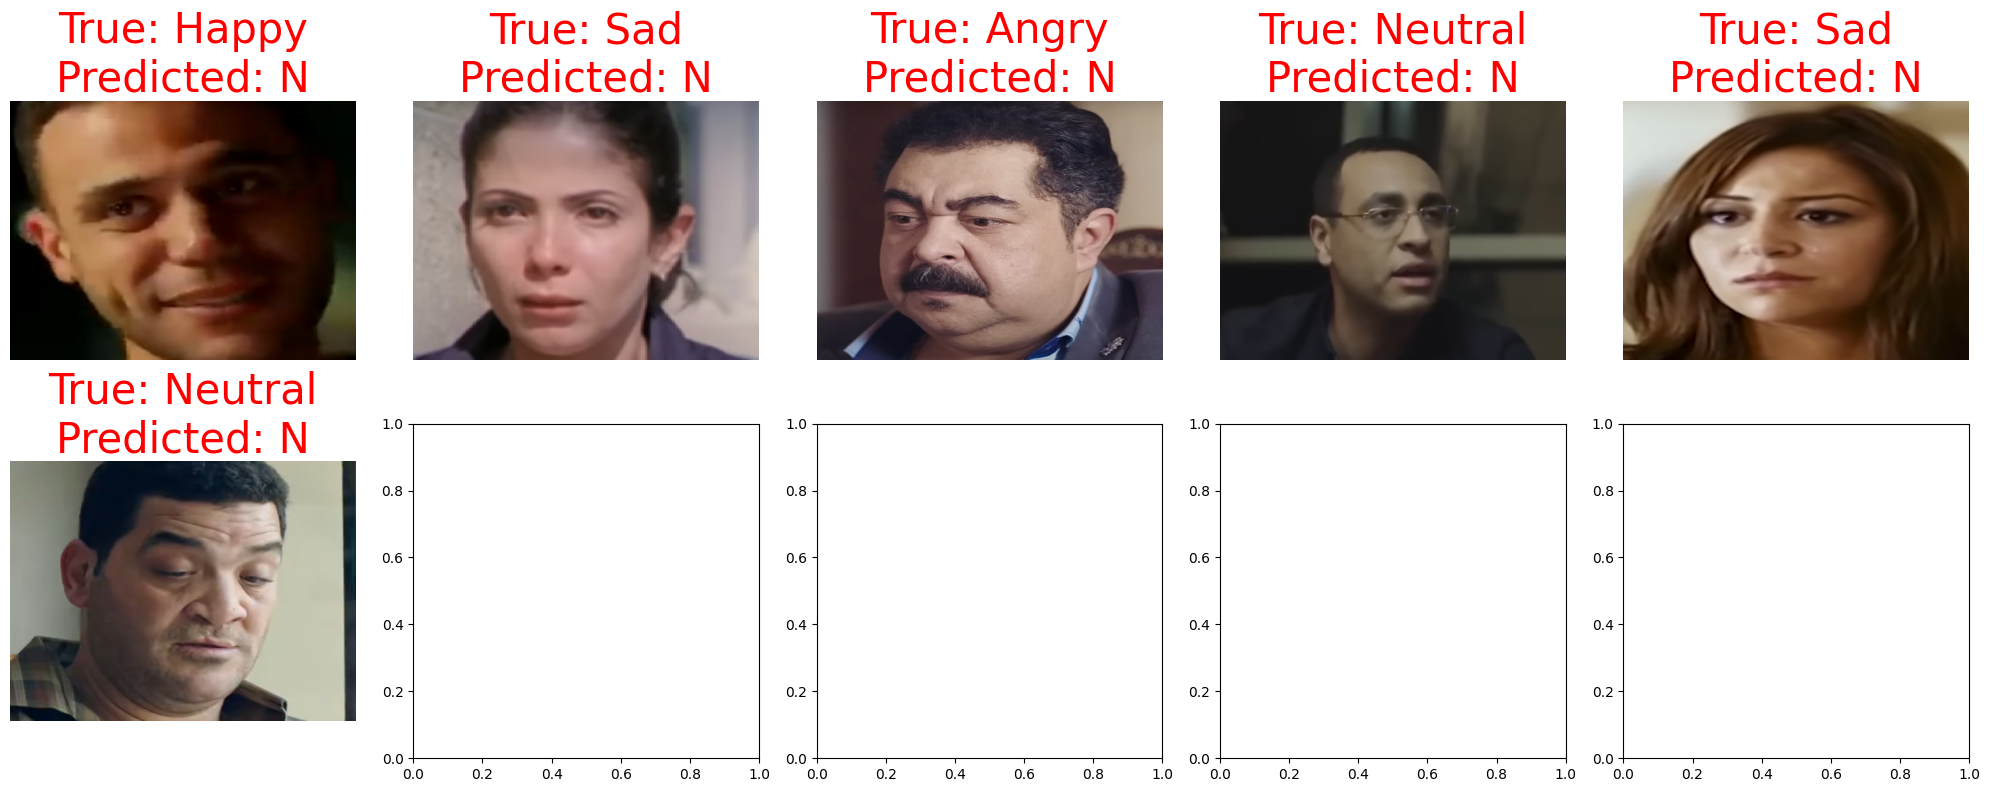

In [16]:
test_samples_count = min(10, len(test_df))
test_samples = test_df.sample(test_samples_count)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, (index, row) in enumerate(test_samples.iterrows()):
    img = Image.open(row['img_path'])
    true_label = row['label']
    predicted_label = test_predicted_labels[i]
    
    title_color = 'green' if true_label == predicted_label else 'red'
    
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(
        f"True: {true_label}\nPredicted: {predicted_label}",
        fontsize=30,  
        color=title_color  
    )
    axes[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

## **Model 2**

### Build model 2

In [17]:
# TA : "You should have 5 convolution blocks each with 3 layers.
#  3 convolution layers are simply 3 different filters on the same stage.
#  A convolution block is some conv filters (layers) followed by an activation function and then a max pooling. 
# All convolution filters in the same block need to have the same size."

def create_model2():
    model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(TAREGT_SIZE_TUPLE[0], TAREGT_SIZE_TUPLE[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(DENSE_LAYER_UNITS, activation='sigmoid'),
    layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

model2 = create_model2()


print("done building model 2")

/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


done building model 2


E0000 00:00:1745823769.236394   19215 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745823769.237583   19215 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Visualize model 2 architecture

In [18]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 508, 508, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 506, 506, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 253, 253, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 251, 251, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 249, 249, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 247, 247, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 123, 123, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 121, 121, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 119, 119, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 117, 117, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 54, 54, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 50, 50, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 46, 46, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 17, 17, 16)     │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 16)     │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 5, 5, 16)       │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,084 (1.47 MB)

 Trainable params: 384,084 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

### Early stopping to prevent overfitting (for the BONUS)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

### Data augmentation (for the BONUS)

In [20]:
# thiss will rotate the images by up to 20 degrees, also will increase the 
# dataset size on the fly while training 

# the rescaling is done to normalize the pixel values to be between 0 and 1, for more numerical stability while training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=IMAGE_DATA_GENERATOR_RORATION_ANGLE,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Model 2 training

In [21]:
start_time = time()

# print trining dataset size before and after augmentation, note that augmentation increases the training dataset size
print(f"Training dataset size before augmentation: {len(train_df)}")
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=TAREGT_SIZE_TUPLE,
    x_col='img_path',  
    y_col='label',    
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=True
)
print(f"Training dataset size after augmentation: {train_gen.n}")

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    target_size=TAREGT_SIZE_TUPLE,
    x_col='img_path',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
print(f"images sizes passed to image data generator: {train_gen.image_shape}")


model2_history = model2.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=[early_stoping, learning_rate_reduction],
    epochs=EPOCHS,
)

print(f"Val accuracy: {model2_history.history['val_accuracy'][-1]:.2f}")
calculate_and_print_time(start_time, "Training model 2")


Training dataset size before augmentation: 39
Found 39 validated image filenames belonging to 4 classes.
Training dataset size after augmentation: 39
Found 11 validated image filenames belonging to 4 classes.


/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


images sizes passed to image data generator: (512, 512, 3)


2025-04-28 10:02:54.569220: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532684800 exceeds 10% of free system memory.
2025-04-28 10:02:54.695197: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528515072 exceeds 10% of free system memory.
2025-04-28 10:02:54.931519: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 524361728 exceeds 10% of free system memory.
2025-04-28 10:02:58.412433: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 524361728 exceeds 10% of free system memory.
2025-04-28 10:02:58.824989: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 528515072 exceeds 10% of free system memory.


3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.2454 - loss: 1.3970 - val_accuracy: 0.2727 - val_loss: 1.3844 - learning_rate: 0.0010
Val accuracy: 0.27

Training model 2 Done in : 0 h, 0 m, 25 s


### Testing model 2 on the test set

In [22]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=TAREGT_SIZE_TUPLE,
    x_col='img_path',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_acc = model2.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.2f}")

Found 6 validated image filenames belonging to 4 classes.


/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - accuracy: 0.1667 - loss: 1.4042
Test accuracy: 0.17


### Disply sample inputs and outputs from for model 2 (for the report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


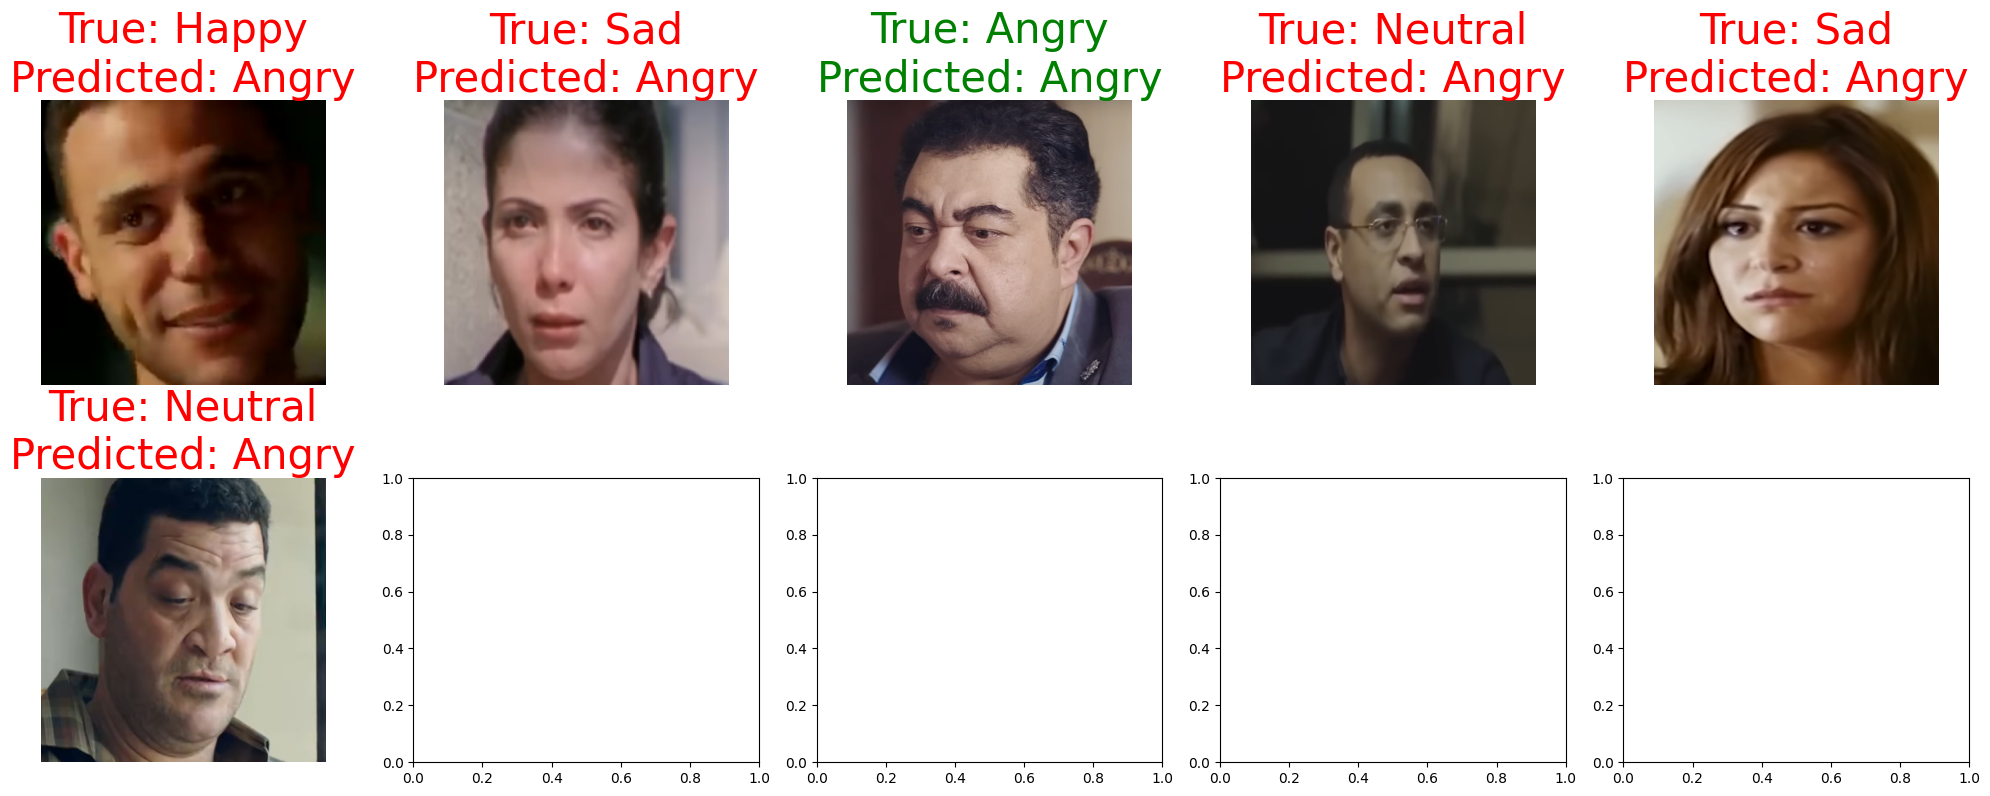

In [23]:
# Map class indices to class names
class_indices = train_gen.class_indices  
class_labels = {v: k for k, v in class_indices.items()} 

test_images = np.stack(test_samples['img_arr'].values)
# Normalize test images because the image was trained on normalized images
test_images = test_images / 255.0  

predicted_probs = model2.predict(test_images)
predicted_classes = np.argmax(predicted_probs, axis=1) 

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (index, row) in enumerate(test_samples.iterrows()):
    img = row['img_arr']
    true_label = row['label']
    predicted_label = class_labels[predicted_classes[i]]
    
    title_color = 'green' if true_label == predicted_label else 'red'
    
    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {true_label}\nPredicted: {predicted_label}",
        fontsize=30, 
        color=title_color
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()